In [1]:
import os
import cv2
import numpy as np
from moviepy.editor import VideoFileClip
import matplotlib.pyplot as plt
test_path = './test_images'
challenge_video = './challenge_video.mp4'
harder_challenge_video = './harder_challenge_video.mp4'
clb_path = './camera_cal'

In [2]:
def cvt(img):
    return cv2.cvtColor(img, cv2.COLOR_RGB2BGR)

challenge_clip = VideoFileClip(challenge_video)
print(challenge_clip.duration)

frame = challenge_clip.get_frame(15.00)
cv2.imwrite(os.path.join(test_path, "frame170.jpg"), cvt(frame))


16.15


True

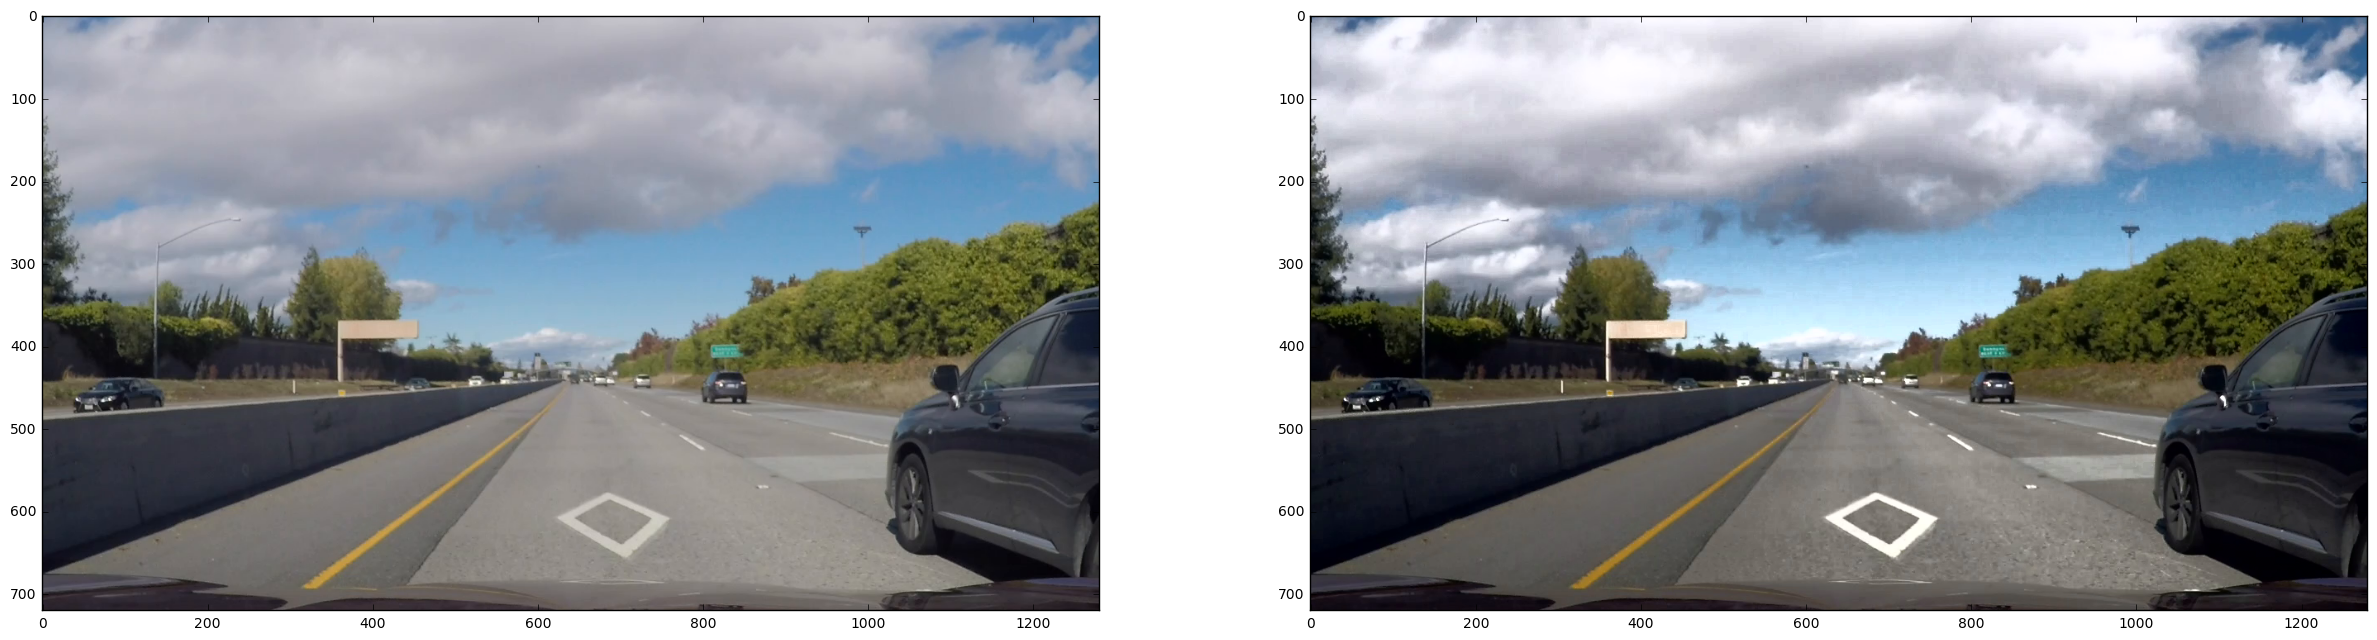

In [3]:
yuv = cv2.cvtColor(frame, cv2.COLOR_RGB2YUV)
clahe = cv2.createCLAHE()
yuv[:,:,0] = cv2.equalizeHist(yuv[:,:,0])
img = cv2.cvtColor(yuv, cv2.COLOR_YUV2RGB)

plt.rcParams['figure.figsize'] = (30, 10)
plt.subplot(121)
plt.imshow(frame)
plt.subplot(122)
plt.imshow(img)
plt.show()

In [4]:
from utils.eye import undistort_eye, depth_eye
from utils.thresholding import *
from utils.lane_track import tracker
from utils.factory import pipeline

def color_mask(img):
    gray = np.mean(img, 2)
    mask_gray = color_threshold(gray, thres = (196, 255)) # good at finding write lane
    v = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)[:,:,2]
    mask_v = color_threshold(v, thres = (0, 110)) # good at finding yellow lane
    mask = (mask_gray | mask_v)
    return mask

def gradient_mask(img):
    chs = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    mask = gradient_threshold(chs[:,:,2], type = 'magnitude', kernelx = 3, kernely = 1, thres = (40, 100))
    return mask

def Cup(img, torgb = False):
    cvt = cv2.COLOR_BGR2YUV if torgb else cv2.COLOR_RGB2YUV
    inv = cv2.COLOR_YUV2BGR if torgb else cv2.COLOR_YUV2RGB
    yuv = cv2.cvtColor(img, cvt)
    clahe = cv2.createCLAHE(clipLimit = 1.5, tileGridSize = (8,8))
    yuv[:,:,0] = clahe.apply(yuv[:,:,0])
    result = cv2.cvtColor(yuv, inv)
    return result



src = np.float32([[280, 720], [1040, 720], [700, 470], [620, 470]])
dst = np.float32([[400, 720],[880, 720], [880, 0], [400, 0]])

undist_eye = undistort_eye(clb_path, 9, 6)
p_eye = depth_eye(frame.shape, src, dst)
trk = tracker(40, 18, 20, 14.64/270, frac = 2, curv_count = 1570)
pipe = pipeline(undist_eye, p_eye, trk, [Cup, color_mask], weight = 0.9)


In [5]:
pipe_out = './output_images/pipeline'
undist_frame = undist_eye.cal_undist(frame)
cv2.imwrite(os.path.join(pipe_out, 'undist.png'), cvt(undist_frame))
grad_frame = gradient_mask(undist_frame)
cv2.imwrite(os.path.join(pipe_out, 'grad.png'), np.dstack([grad_frame]*3)*255)
color_frame = color_mask(Cup(undist_frame))
cv2.imwrite(os.path.join(pipe_out, 'color.png'), np.dstack([color_frame]*3)*255)
warped = p_eye.transform(color_frame)
cv2.imwrite(os.path.join(pipe_out, 'warped.png'), np.dstack([warped]*3)*255)
lanes = trk.lane(warped, win_color = [0, 255, 0])
cv2.imwrite(os.path.join(pipe_out, 'lanes.png'), cvt(lanes))
cv2.imwrite(os.path.join(pipe_out, 'final.png'), cvt(pipe.make(frame)))

True

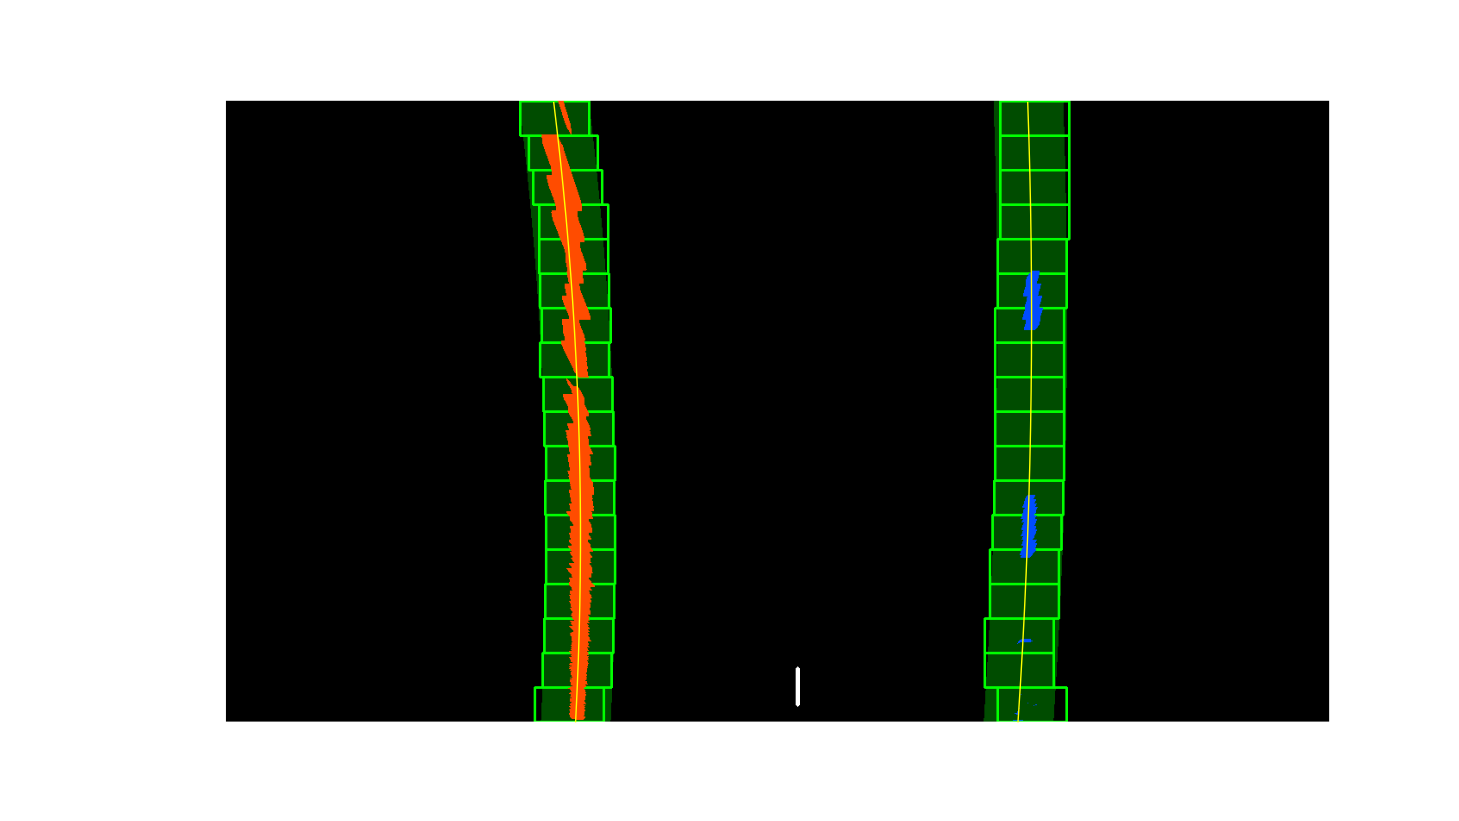

In [6]:
out_img = lanes
window_img = np.zeros_like(out_img)

# Generate a polygon to illustrate the search window area
# And recast the x and y points into usable format for cv2.fillPoly()
ploty = np.linspace(0, 719, 720)
left_fitx = np.polyval(trk.fit[0], ploty)
right_fitx = np.polyval(trk.fit[1], ploty)
margin = 40

left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
left_line_pts = np.hstack((left_line_window1, left_line_window2))
right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
right_line_pts = np.hstack((right_line_window1, right_line_window2))

# Draw the lane onto the warped blank image
cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
plt.imshow(result)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.axis('off')
plt.show()

In [7]:
color_frame = color_mask(undist_frame)
warped = p_eye.transform(color_frame)
cv2.imwrite(os.path.join(pipe_out, 'no_Cup_color.png'), np.dstack([warped]*3)*255)

True